## Demonstrating online learning using Bayesian linear regression;

### Assumptions:
* Given parameters, $w$, and inputs $x$, targets, $y$, are independent and identically distributed.
* **Note:** the covariance of $y|x$ is not diagonal in general if not conditioned on the latent parameters $w$. 
* Each observation's conditional distribution on inputs and parameters is Gaussian.
* The prior for the parameters is a zero mean isotropic Gaussian.

### In terms of maths;
* $\{(y_i| w, x_i)\}_{i=1}^N$ i.i.d.
* $f(y_i|x_i, w) = \mathcal{N}(y_i|w^T\phi(x_i), \sigma^2)$, where $\phi:\mathbb{R}^m\rightarrow \mathbb{R}^d$.
* $\pi(w) = \mathcal{N}(w|0, \alpha^{-1}I)$.

### Posterior update for general Normal prior (i.e. $w\sim\mathcal{N}\left(\mu, \Sigma\right)$):
* $\pi(w|y, x)\propto f(y|x, w)\pi(w)$
* $\pi(w|y, x)\propto \Pi_{i=1}^Nf(y_i|x_i, w)\pi(w)$
* $\pi(w|y, x)\propto \exp\left(- \frac{1}{2\sigma^2}\Sigma_{i=1}^N(y_i-w^T\phi(x_i))^2\right)\exp\left(-\frac{1}{2}(w-\mu)^T\Sigma^{-1}(w-\mu)\right)$
* $\pi(w|y, x)\propto\exp\left(-\frac{1}{2\sigma^2}(y-\Phi w)^T(y-\Phi w)\right)\exp\left(-\frac{1}{2}(w-\mu)^T\Sigma^{-1}(w-\mu)\right)$
* $\pi(w|y, x)\propto\exp\left(-\frac{1}{2}\left[\frac{1}{\sigma^2}\left(-2y^T\Phi w + w^T\Phi^T\Phi w\right) + w^T\Sigma^{-1}w - 2\mu^T\Sigma^{-1}w\right]\right)$
* $\pi(w|y, x)\propto\exp\left(-\frac{1}{2}\left[w^T\left(\frac{1}{\sigma^2}\Phi^T\Phi + \Sigma^{-1}\right)w - 2\left(\frac{1}{\sigma^2}y^T\Phi + \mu^T\Sigma^{-1}\right)w\right]\right)$

Hence:
* $w|y, x\sim\mathcal{N}(m_N, S_N)$
* where:
    * $S_N^{-1}=\frac{1}{\sigma^2}\Phi^T\Phi + \Sigma^{-1}$
    * $m_N^T=\left(\frac{1}{\sigma^2}y^T\Phi + \mu^T\Sigma^{-1}\right)S_N$

### Online learning:
* As a new data point comes, calculate a new posterior and use that as the prior when the next datapoint comes.
* $\pi(w|x_{:i+1}, y_{:i+1})\propto f(y_{i+1}|x_{i+1}, w)\pi(w|x_{:i}, y_{:i})$.


### Zero-mean, isotropic Gaussian prior (i.e. $w\sim\mathcal{N}\left(0, \alpha^{-1}I\right)$:
Note that:
* $\log(\pi(w|y, x))\propto\log(f(y|w, x)) + \log(\pi(w))$
* $\log(\pi(w|y, x))\propto-\frac{1}{2\sigma^2}\Sigma(y_i - w^T\phi(x_i))^2 - \frac{\alpha}{2}w^Tw$
* $-2\sigma^2\log(\pi(w|y, x))\propto\Sigma(y_i - w^T\phi(x_i))^2 + \alpha\sigma^2w^Tw$
* So estimating $w$ via MAP in the case of zero mean, isotropic Gaussian prior with precision $\alpha$ amounts to least squares estimation with $l^2$ norm regularisation with $\lambda=\alpha\sigma^2$ (set lower magnitudes for "less important" features).
* So we can control how much regularisation we want via the precision parameter $\alpha$ of the prior for the parameters. Higher precision (low variance in the $w$ prior) leads to greater contribution from the $l^2$ norm, hence more pressure on the parameters to have low magnitudes. On the other hand, high uncertainty (low precision, $\alpha\rightarrow 0$) leads to the ML estimates.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(["dark_background"])
np.random.seed(42)

### Simulate data;

In [2]:
SAMPLE_SIZE = 200
a, b = -0.3, 0.5
x = np.random.uniform(-1, 1, SAMPLE_SIZE)
noise_sigma = 0.2
y = a + b * x + np.random.normal(0, noise_sigma, SAMPLE_SIZE)
param_precision = 2
m0 = np.zeros((2, 1), dtype=float)
s0 = np.eye(2) / param_precision

In [3]:
w0, w1 = np.linspace(-2, 2, 40), np.linspace(-2, 2, 40)
w0, w1 = np.meshgrid(w0, w1, indexing="ij")
# ij indexing means w0[i, :] = w0_1d[i] and w1[:, i] = w1_1d[i]

### Some utility functions for calculating likelihoods;

In [4]:
def get_single_likelihood(x, y, w0, w1, noise_sigma):
    return (np.exp(- ((y - w0 - w1 * x) ** 2) / (2 * noise_sigma ** 2)) /\
            (np.sqrt(2 * np.pi) * noise_sigma))

In [5]:
def eval_multi_gauss(w0, w1, mu, sigma):
    w = np.array([w0, w1], dtype=float).reshape(-1, 1)
    mu = mu.reshape(-1, 1)
    return (np.exp(- (w - mu).T @ np.linalg.inv(sigma) @ (w - mu) / 2) /\
            (2 * np.pi * np.sqrt(np.linalg.det(sigma))))

def get_many_multigaussians(w0, w1, mu, sigma):
    gaussians = np.empty((w0.shape[0], w1.shape[1]), dtype=float)
    for i in range(w0.shape[0]):
        for j in range(w1.shape[1]):
            gaussians[i][j] = eval_multi_gauss(w0[i][j], w1[i][j], mu, sigma)
    return gaussians

In [6]:
def update_posterior(noise_sigma, m0, s0, y, x):
    phi = np.ones((x.shape[0], 2))
    phi[:, 1] = x
    m0 = m0.reshape(-1, 1)
    sn = np.linalg.inv(phi.T @ phi / noise_sigma ** 2 + np.linalg.inv(s0))
    mn = (y.T @ phi / noise_sigma ** 2 + m0.T @ np.linalg.inv(s0)) @ sn
    return mn, sn

### Create the plot;
* First column shows likelihood evaluated over a grid of parameter values for one data point;
* Second column shows prior/posterior distribution over a grid of parameter values;
* Third column shows sampled regression functions from the prior/posterior shown in the second column;
* We can see how the posterior has less and less uncertainty as we consider more data points;
* Initially the lines in the third column aim to pass through the single observation considered, however, as we see more data, the lines begin to agree more over the region where we have data.

In [7]:
def plot_online_learning(w0, w1, m0, s0, true_a, true_b, noise_sigma, 
                         x, y, steps=None, figsize=(12, 17)):
    if steps is None:
        steps = []
    
    fig, axs = plt.subplots(nrows=max(2, len(steps) + 1), ncols=3, figsize=figsize)
    
    # plot prior;
    gaussians = get_many_multigaussians(w0, w1, m0, s0)
    axs[0][1].contourf(w0, w1, gaussians, levels=10, alpha=0.6)
    axs[0][1].axis("scaled")
    axs[0][1].scatter(true_a, true_b, marker='+', color='r', s=200)
    axs[0][1].set_xlabel("$w_0$")
    axs[0][1].set_ylabel("$w_1$")
    axs[0][1].set_title("prior")
    
    # sample regression functions from prior;
    samples = np.random.multivariate_normal(m0.reshape(-1), s0, 6)
    x_samples = np.linspace(-1.1, 1.1, 50)
    for i in range(samples.shape[0]):
        axs[0][2].plot(x_samples, samples[i][0] + samples[i][1] * x_samples, color="magenta")
    axs[0][2].set_xlabel("$x$")
    axs[0][2].set_ylabel("$w_0 + w_1x$")
    axs[0][2].set_title("sampled regression functions")
    
    prev_step = 0
    for i, step in enumerate(steps, 1):
        # get and plot likelihood;
        l0 = get_single_likelihood(x[step], y[step], w0, w1, noise_sigma)
        axs[i][0].contourf(w0, w1, l0, levels=10, alpha=0.6)
        axs[i][0].axis("scaled")
        axs[i][0].set_title(f"likelihood for {step+1}th observation")
        axs[i][0].set_xlabel("$w_0$")
        axs[i][0].set_ylabel("$w_1$")
        
        # update posterior and plot it;
        m0, s0 = update_posterior(noise_sigma, m0, s0, y[prev_step:step+1], x[prev_step:step+1])
        gaussians = get_many_multigaussians(w0, w1, m0, s0)
        axs[i][1].contourf(w0, w1, gaussians, levels=10, alpha=0.6)
        axs[i][1].axis("scaled")
        axs[i][1].scatter(true_a, true_b, marker='+', color='r', s=200)
        axs[i][1].set_xlabel("$w_0$")
        axs[i][1].set_ylabel("$w_1$")
        axs[i][1].set_title(f"posterior after {step+1} observations")
        
        # sample regression functions and plot them;
        samples = np.random.multivariate_normal(m0.reshape(-1), s0, 6)
        for j in range(samples.shape[0]):
            axs[i][2].plot(x_samples, samples[j][0] + samples[j][1] * x_samples, color="magenta")
            axs[i][2].scatter(x[:step+1], y[:step+1], 
                             marker='s', s=120, color="green")
        axs[i][2].set_xlabel("$x$")
        axs[i][2].set_ylabel("$w_0 + w_1x$")
        axs[i][2].set_title("sampled regression functions")
        
        prev_step = step+1
    fig.tight_layout()
    plt.savefig("blr_online_learning.png")
    return m0, s0

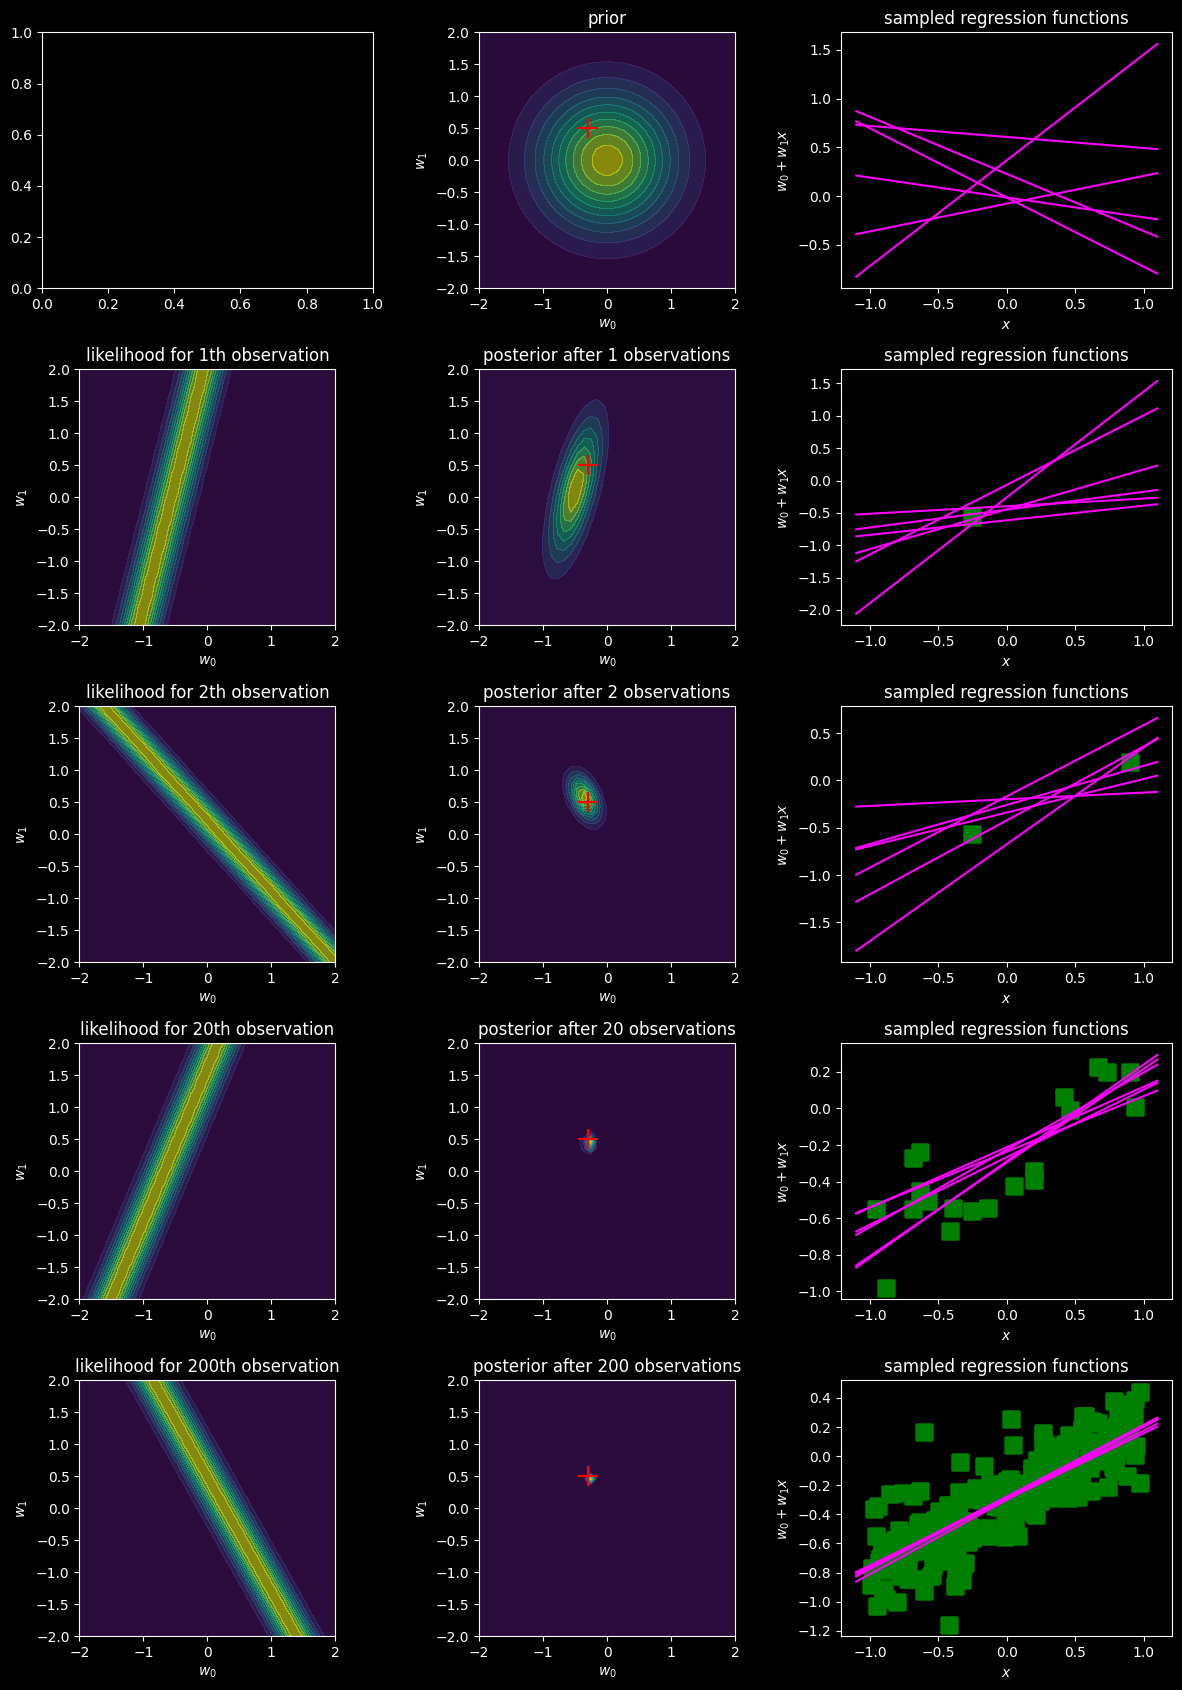

In [8]:
mn, sn = plot_online_learning(w0, w1, m0, s0, a, b, noise_sigma, x, y, steps=[0, 1, 19, 199])

### For the Gaussian posterior, the MAP estimates can be read off from the posterior mean;

In [9]:
print(f"True parameters:\nw0 = {a:.3f}\nw1 = {b:.3f}",
      f"MAP estimate for parameters:\nw0 = {mn[0][0]:.3f}\nw1 = {mn[0][1]:.3f}",
      f"with covariance matrix:\n{sn.round(5)})",sep="\n\n")

True parameters:
w0 = -0.300
w1 = 0.500

MAP estimate for parameters:
w0 = -0.287
w1 = 0.492

with covariance matrix:
[[2.0e-04 2.0e-05]
 [2.0e-05 5.8e-04]])
